In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, auc, plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import eli5
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df1_test = pd.read_csv('../data/ht_match_na.csv')
df2_test = pd.read_csv('../data/ht_match_ind_na.csv')

df = df_join(df1,df2)
df_test = df_join(df1_test, df2_test)

In [8]:
y = df['win']
X = df.drop(columns=['match_id','win'])

X_cols = X.columns

#### Converting team names ('red', 'blue') to 1 and 0

In [9]:
mask = {'blue':0,'red':1}
X['teams'] = X['teams'].replace(mask)

df_test['teams'] = df_test['teams'].replace(mask)

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [11]:
num_features, cat_features = feature_separator(X)

In [12]:
scaled_pl = pipeline(True,num_features,False, True)
unscaled_pl = pipeline(True,num_features,False, False)

In [13]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [14]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.91
Recall score for scaled log reg: 0.87


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.90
Recall score for unscaled random forest: 0.90


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.90
Recall score for scaled gradient boost: 0.87


Mean cross validatin score for scaled Bayesian: 0.84
Precision score for scaled Bayesian: 0.85
Recall score for scaled Bayesian: 0.83




## Comparing ROC AUC Curves for base models

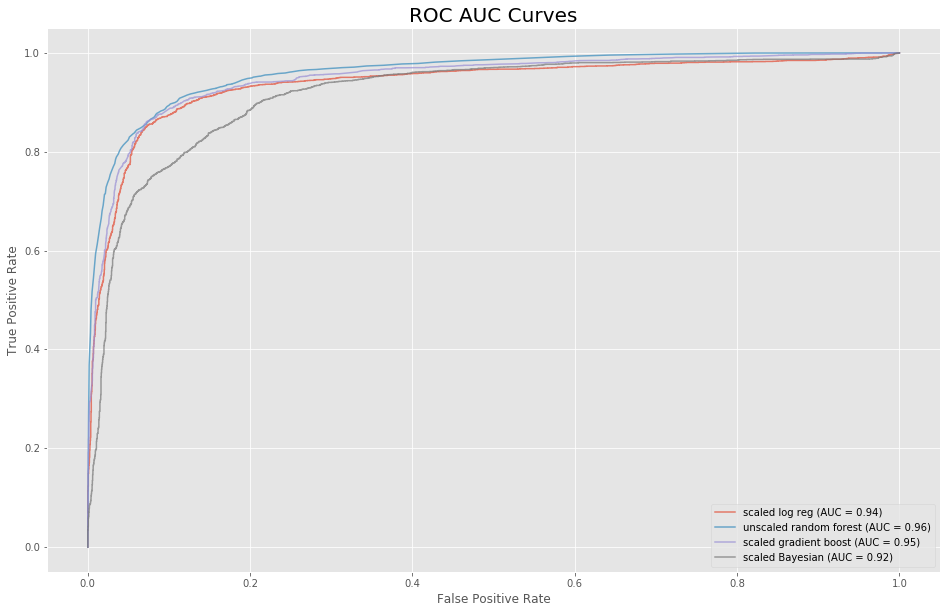

In [15]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X, y)

## Feature engineering before tuning hyperparameters with a selected model

##### Logistic regression coefficients

In [16]:
full_features = list(X_cols)
print(f"Coefficients: {lrc_s.fit(X_train,y_train).named_steps['estimator'].coef_}")
print(f'roc auc score: {roc_auc_score(y_validation,lrc_s.fit(X_train,y_train).predict(X_validation)):.2f}')
weight_explainer(lrc_s,full_features)

Coefficients: [[-2.31314277 -1.81246101  3.26440039  0.58177789 -0.50783367 -0.0662117
   0.01725698  0.31780599  1.29757764  3.68725951  1.95143045  0.81569796
   0.12668474]]
roc auc score: 0.89


Weight?,Feature
+3.687,xp
+3.264,firstTower
+1.951,totalKills
+1.298,level
+0.816,totalDeaths
+0.582,firstInhibitor
+0.318,totalGold
+0.127,level_ups
+0.017,firstRiftHerald
-0.066,firstDragon


In [17]:
precision_score(y_validation,lrc_s.fit(X_train,y_train).predict(X_validation))

0.9103671706263499

In [18]:
# removed  xp
remove_list = ['xp']
reduced_features1 = [i for i in full_features if i not in remove_list]

X_reduced = X[reduced_features1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, test_size=0.3)

reduced_pl = scaled_pl = pipeline(True,reduced_features1,False, True)
reduced_lrc = append_model(LogisticRegression(), reduced_pl)
reduced_rfc = append_model(RandomForestClassifier(), reduced_pl)

print(f"Coefficients: {reduced_lrc.fit(X_reduced,y).named_steps['estimator'].coef_}")

print(f'roc auc score: {roc_auc_score(y_test2,reduced_lrc.fit(X_train2,y_train2).predict(X_test2)):.2f}')

weight_explainer(reduced_lrc.fit(X_reduced,y),reduced_features1)

Coefficients: [[ 0.01876236  0.12809741  0.6603768   1.8223404   0.84129768  0.42098315
   0.06790849 -1.07185818  0.74714149  0.49917866 -0.54224462 -0.54715173]]
roc auc score: 0.89


Weight?,Feature
+1.822,firstInhibitor
+0.841,firstBaron
+0.747,level
+0.660,firstTower
+0.499,totalKills
+0.421,firstDragon
+0.351,<BIAS>
+0.128,firstBlood
+0.068,firstRiftHerald
+0.019,teams


In [19]:
precision_score(y_test2,reduced_lrc.fit(X_train2,y_train2).predict(X_test2))

0.9034032313509797

In [20]:
## Removed totalGold and level
remove_list = ['totalGold','level']
reduced_features2 = [i for i in full_features if i not in remove_list]

X_reduced2 = X[reduced_features2]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_reduced2, y, test_size=0.3)

reduced_pl2 = scaled_pl = pipeline(True,reduced_features2,False, True)
reduced_lrc2 = append_model(LogisticRegression(), reduced_pl2)

print(f"Coefficients: {reduced_lrc.fit(X_reduced,y).named_steps['estimator'].coef_}")

print(f'roc auc score: {roc_auc_score(y_test3,reduced_lrc2.fit(X_train3,y_train3).predict(X_test3)):.2f}')

weight_explainer(reduced_lrc2.fit(X_reduced2,y),reduced_features2)

Coefficients: [[ 0.01876236  0.12809741  0.6603768   1.8223404   0.84129768  0.42098315
   0.06790849 -1.07185818  0.74714149  0.49917866 -0.54224462 -0.54715173]]
roc auc score: 0.89


Weight?,Feature
+1.816,firstInhibitor
+0.832,firstBaron
+0.645,firstTower
+0.425,firstDragon
+0.356,totalKills
+0.340,<BIAS>
+0.109,firstBlood
+0.066,firstRiftHerald
+0.018,teams
-0.254,xp


In [21]:
precision_score(y_test3,reduced_lrc2.fit(X_train3,y_train3).predict(X_test3))

0.8981324278438031

In [22]:
## Removed xp, totalGold and level
remove_list = ['xp','totalGold','level']
reduced_features3 = [i for i in full_features if i not in remove_list]

X_reduced3 = X[reduced_features3]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_reduced3, y, test_size=0.3)

reduced_pl3 = scaled_pl = pipeline(True,reduced_features3,False, True)
reduced_lrc3 = append_model(LogisticRegression(), reduced_pl3)

print(f"Coefficients: {reduced_lrc.fit(X_reduced,y).named_steps['estimator'].coef_}")

print(f'roc auc score: {roc_auc_score(y_test4,reduced_lrc3.fit(X_train4,y_train4).predict(X_test4)):.2f}')

weight_explainer(reduced_lrc3.fit(X_reduced3,y),reduced_features3)

Coefficients: [[ 0.01876236  0.12809741  0.6603768   1.8223404   0.84129768  0.42098315
   0.06790849 -1.07185818  0.74714149  0.49917866 -0.54224462 -0.54715173]]
roc auc score: 0.89


Weight?,Feature
+1.798,firstInhibitor
+0.808,firstBaron
+0.652,firstTower
+0.435,firstDragon
+0.318,<BIAS>
+0.314,totalKills
+0.111,firstBlood
+0.074,firstRiftHerald
+0.018,teams
-0.608,level_ups


In [23]:
precision_score(y_test4,reduced_lrc3.fit(X_train4,y_train4).predict(X_test4))

0.9133663366336634

In [24]:
X_train_r1, X_test_r1, y_train_r1, y_test_r1 = train_test_split(X_reduced, y, test_size=0.3)

In [25]:
X_train_r2, X_test_r2, y_train_r2, y_test_r2 = train_test_split(X_reduced2, y, test_size=0.3)

##### Random forest feature importance

In [26]:
reduced_rfc.fit(X_reduced,y)
weight_explainer(reduced_rfc,reduced_features1)

Weight,Feature
0.3376 ± 0.1983,firstInhibitor
0.1010 ± 0.1234,firstTower
0.1001 ± 0.0369,totalGold
0.0965 ± 0.0538,totalDeaths
0.0912 ± 0.0406,level
0.0735 ± 0.0969,firstBaron
0.0667 ± 0.0452,totalKills
0.0530 ± 0.0291,level_ups
0.0348 ± 0.0566,firstDragon
0.0213 ± 0.0394,firstRiftHerald


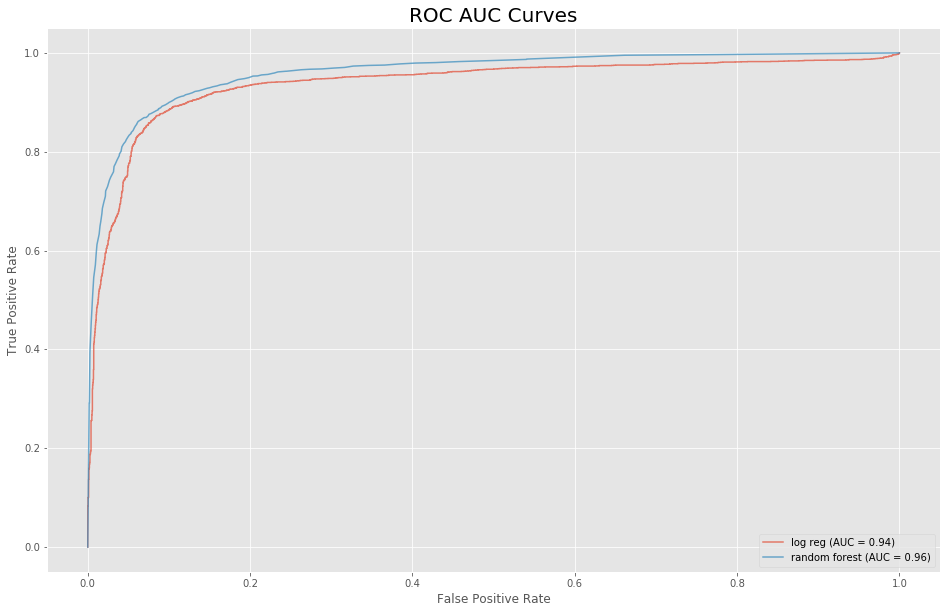

In [27]:
fig,ax = plt.subplots(figsize=(16,10))

clfs = {'log reg': reduced_lrc,'random forest': reduced_rfc}
roc_auc_plot(ax, clfs, X_reduced, y)

In [28]:
clfs2 = {'logreg':reduced_lrc2}
roc_auc_plot(ax, clfs2, X_reduced2, y)

Which features to use before hyperparameter tuning?

## Tuning hyperparameters

In [ ]:
params = {'estimator__n_estimators': (10, 100,1000,10000),
         'estimator__max_depth': (2,4,6,None),
         'estimator__max_features': (3,6,'auto'),
         }

search = GridSearchCV(rfc_u,params,n_jobs=-1,verbose=1)
search.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min


In [ ]:
search.best_params_

## CV score against the entire training dataset

## Confusion Matrix

## Using the best model against the test dataset

## Result